# Wide FOV Metasurface

This is reproduction of the results in 1(b) using Diffraction Monitor. Parameters from [the paper](https://duke.box.com/s/xvysh66ew21g9o9e5pjcd11o11bzo73t):

$$P= 190nm$$
$$h= 230nm$$
$$D= [60, 135]nm$$
$$\lambda = 532nm$$

![](../assets/power_wfov.png)

---

![](../assets/phase_wfov.png)

---

In [1]:
# Import the necessary packages
import matplotlib.pyplot as plt
import numpy as np
import tidy3d as td
import tidy3d.web as web
import scienceplots

# Set logging level to ERROR to reduce output verbosity
td.config.logging_level = "ERROR"

In [2]:
# 0 Define a FreqRange object with desired wavelengths
lda0 = 0.532
freq0 = td.C_0 / lda0
print("%E" % freq0)

5.635197E+14


In [3]:
# 1 Computational Domain Size
h = 0.230  # Height of cylinder
spc = 1
Lz = spc + h + h + spc

Px = Py = P = 0.190 # periodicity
sim_size = [Px, Py, Lz]

In [4]:
# 2 Grid Resolution
dl = P / 32
horizontal_grid = td.UniformGrid(dl=dl)
vertical_grid = td.AutoGrid(min_steps_per_wvl=32)
grid_spec=td.GridSpec(
    grid_x=horizontal_grid,
    grid_y=horizontal_grid,
    grid_z=vertical_grid,
)

In [5]:
sap = td.material_library['Sapphire']['Horiba']
si = td.material_library['cSi']['Green2008']

substrate = td.Structure(
    geometry=td.Box(
        center=(0,0,-Lz/2),
        size=(td.inf,td.inf,2 * (spc+h))
    ),
    medium=sap,
    name='substrate'
)

In [6]:
source = td.PlaneWave(
    source_time=td.GaussianPulse(freq0=freq0, fwidth=20e12),
    size=(td.inf, td.inf,0),
    center=(0, 0, Lz/2 - spc + 0.5 * lda0),
    direction="-",
    pol_angle=0
)

In [7]:
monitor = td.DiffractionMonitor(
    center=(0, 0, -Lz/2 + spc - 0.5 * lda0),
    size=(td.inf,td.inf,0),
    freqs=[freq0],
    name='diffraction_monitor',
    normal_dir='-', # away from structure
)

In [8]:
bc = td.BoundarySpec(
    x=td.Boundary.periodic(), 
    y=td.Boundary.periodic(), 
    z=td.Boundary.pml()
)

In [9]:
D = np.arange(0.060, 0.140, 0.005)
print(D)
sims = {}
run_time = 50

def simulate(D):
    for i, diameter in enumerate(D):
        cylinder = td.Structure(
            geometry=td.Cylinder(
                center=[0, 0, h / 2], 
                radius=diameter/2, 
                length=h, 
            axis=2), 
            medium=si
        )
        
        sim = td.Simulation(
            size = sim_size,
            grid_spec = grid_spec,
            structures = [cylinder, substrate],
            sources=[source],
            monitors=[monitor],
            run_time= run_time / freq0,
            boundary_spec=bc
        )

        sims[f"d{i}"] = sim

[0.06  0.065 0.07  0.075 0.08  0.085 0.09  0.095 0.1   0.105 0.11  0.115
 0.12  0.125 0.13  0.135 0.14 ]


dict_keys(['d0', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd10', 'd11', 'd12', 'd13', 'd14', 'd15', 'd16'])


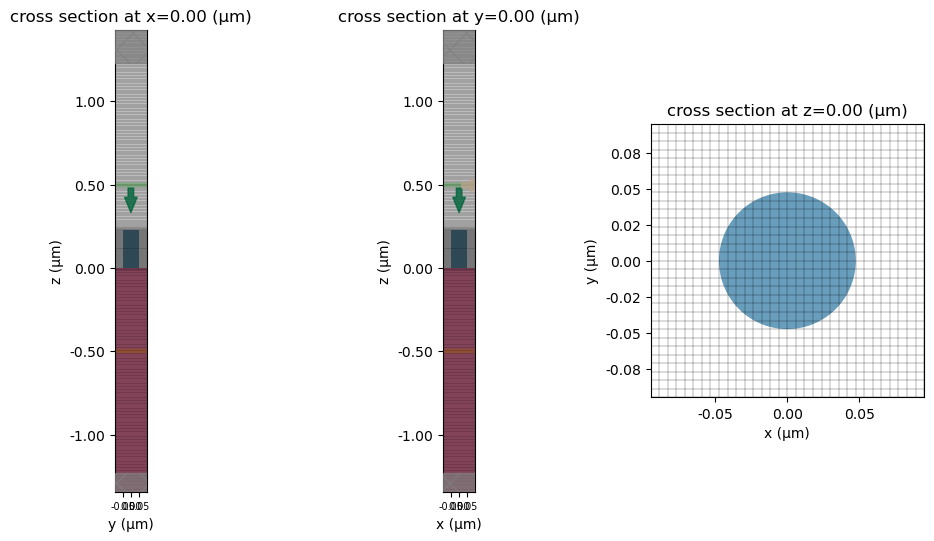

In [10]:
simulate(D)
print(sims.keys())
sim_actual=sims['d7']
# Always visualize simulation before running
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(12, 6))
ax1.tick_params(axis='x', labelsize=7)
ax2.tick_params(axis='x', labelsize=7)
sim_actual.plot(x=0, ax=ax1)
sim_actual.plot_grid(x=0, ax=ax1)
sim_actual.plot(y=0, ax=ax2)
sim_actual.plot_grid(y=0, ax=ax2)
sim_actual.plot(z=0.1, ax=ax3)
sim_actual.plot_grid(z=0, ax=ax3)
plt.show()

In [11]:
batch = web.Batch(simulations=sims, verbose=True)
batch_data = batch.run(path_dir="data/wfov_01")

Output()

21:38:03 EDT Started working on Batch containing 17 tasks.

21:38:16 EDT Maximum FlexCredit cost: 0.425 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

21:38:25 EDT Batch complete.

Output()

In [12]:
dD = []
for i in range(len(D)):
    dD.append(batch_data[f"d{i}"]["diffraction_monitor"])


In [13]:
power = np.array([dD[i].power[0][0] for i in range(len(dD))])

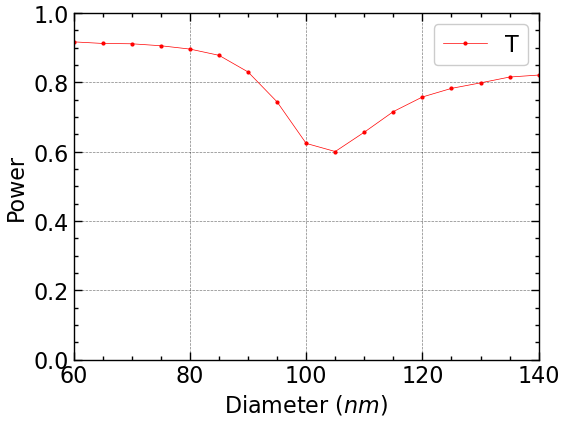

In [14]:
# this uses scienceplots to make plots look better
plt.style.use(['science', 'notebook', 'grid'])
# plot transmission, compare to paper results, look similar
fig, ax = plt.subplots(1, 1, figsize=(6, 4.5))
plt.plot(D*1000, power, "o-", color="red", ms=2, lw=0.5, label="T")
plt.xlabel(r"Diameter ($nm$)")
plt.ylabel("Power")
plt.ylim(0, 1)
plt.xlim(60, 140)
plt.legend()
plt.savefig("power_wfov", dpi=300)
plt.show()

In [15]:
# extract the complex transmission coefficient
t = np.zeros(len(D), dtype="complex")
for i in range(len(D)):
    sim_data = batch_data[f"d{i}"] # go though each simulation result
    t[i] = np.array(sim_data["diffraction_monitor"].amps.sel(f=freq0, polarization="p"))[0][0] # extract complex transmission at freq0

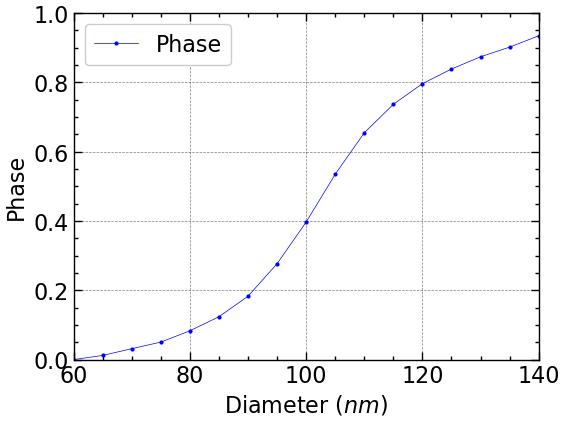

In [21]:
theta = np.unwrap(np.angle(t))
theta = theta - theta[0]
fig, ax = plt.subplots(1, 1, figsize=(6, 4.5))
plt.plot(D*1000, theta / (2 * np.pi), "o-", color="blue", ms=2, lw=0.5, label="Phase")
plt.xlabel(r"Diameter ($nm$)")
plt.ylabel("Phase")
plt.ylim(0, 1)
plt.xlim(60, 140)
plt.legend()
plt.savefig("phase_wfov", dpi=300)
plt.show()

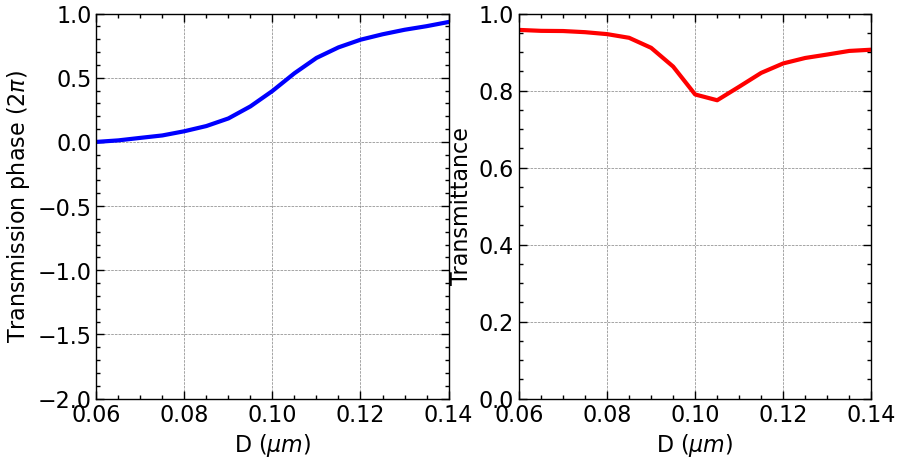

In [22]:
# plot the transmission phase
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
theta = np.unwrap(np.angle(t))
theta = theta - theta[0]
ax1.plot(D, theta / (2 * np.pi), linewidth=3, c="blue")
ax1.set_xlim(np.min(D), np.max(D))
ax1.set_ylim(-2, 1)
ax1.set_xlabel(r"D ($\mu m$)")
ax1.set_ylabel(r"Transmission phase ($2\pi$)")

# plot the transmittance
ax2.plot(D, np.abs(t), linewidth=3, c="red")
ax2.set_xlim(np.min(D), np.max(D))
ax2.set_ylim(0, 1)
ax2.set_xlabel(r"D ($\mu m$)")
ax2.set_ylabel("Transmittance")
plt.show()
ax2.plot(D, np.abs(t), linewidth=3, c="red")
ax2.set_xlim(np.min(D), np.max(D))
ax2.set_ylim(0, 1)
ax2.set_xlabel(r"D ($\mu m$)")
ax2.set_ylabel("Transmittance")
plt.show()